<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/main/AnyNetTest-fixwarning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version
!nvcc --version
!pip3 show torch

In [ ]:
# Clone AnyNet
#!git clone https://github.com/mileyan/AnyNet.git
!git clone -b Colab_Test --single-branch https://github.com/Miragecore/AnyNet.git
%cd /content

In [ ]:
# 디버깅용 코드 블럭
%cd AnyNet
!git pull

In [ ]:
%%writefile setup.sh

### wget reference from => https://linux.tips/tutorials/download-large-google-drive-files-with-wget-in-terminal

### AnyNet Pretrained model : https://drive.google.com/file/d/18Vi68rQO-vcBn3882vkumIWtGggZQDoU/view?usp=sharing
### Anynet Pretrained Model File ID : 18Vi68rQO-vcBn3882vkumIWtGggZQDoU
wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=18Vi68rQO-vcBn3882vkumIWtGggZQDoU' -O 'checkpoint.zip'

#### KITTI Sceneflow https://drive.google.com/file/d/1qm1TEI_trB6_B1je8oRhwbfRIUgs2knH/view?usp=sharing
### file ID : 1qm1TEI_trB6_B1je8oRhwbfRIUgs2knH
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qm1TEI_trB6_B1je8oRhwbfRIUgs2knH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qm1TEI_trB6_B1je8oRhwbfRIUgs2knH" -O KITTI_SceneFlow2015.zip && rm -rf /tmp/cookies.txt

if [ -d "checkpoint" ]; then
  ### Take action if $DIR exists ###
  echo "remove Last pretrained checkpoint.."
  rm -rf checkpoint
fi

echo "unzip pretrained model to checkpoint dir"
unzip checkpoint.zip

if [ -d "KITTI_SceneFlow2015" ]; then
  ### Take action if $DIR exists ###
  echo "remove Last KITTI_SceneFlow2015.."
  rm -rf KITTI_SceneFlow2015
fi

echo "unzip pretrained model to checkpoint dir"
unzip KITTI_SceneFlow2015.zip -d KITTI_SceneFlow2015

mkdir results

###build spn module
cd /content/AnyNet/models/spn_t1
./make.sh

In [ ]:
%cd /content
!chmod +x ./setup.sh
!./setup.sh

In [ ]:
!python /content/AnyNet/finetune.py --maxdisp 192 --with_spn --datapath /content/KITTI_SceneFlow2015/training/ \
    --save_path /content/results/kitti2015 --datatype 2015 --pretrained /content/checkpoint/kitti2015_ck/checkpoint.tar \
    --split_file /content/checkpoint/kitti2015_ck/split.txt --evaluate

In [59]:
import AnyNet.models.anynet as models
from PIL import Image
import PIL
import torchvision.transforms as transforms
import numpy as np
import easydict
import torch.nn as nn
import torch.nn.parallel
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab.patches import cv2_imshow
import cv2

In [46]:
args = easydict.EasyDict({"init_channels": 1 , 
                          "maxdisplist": [12,3,3],  
                          "spn_init_channels" : 8,
                          "nblocks" : 2,
                          "layers_3d" : 4,
                          "channels_3d" : 4,
                          "growth_rate" : [4,1,1],
                          "with_spn" : True,
                          "pretrained" : "/content/checkpoint/kitti2015_ck/checkpoint.tar"})

model = models.AnyNet(args)
model = nn.DataParallel(model).cuda()
checkpoint = torch.load(args.pretrained)
model.load_state_dict(checkpoint['state_dict'], strict=False)

<All keys matched successfully>

In [67]:
#1232, 368
def predict(left, right, crops=(0,0,1232,368)):
  left_img = Image.open(left).convert('RGB')
  right_img = Image.open(right).convert('RGB')
  #print("img shape : " + str(left_img.shape))
  left_img = left_img.crop(crops)
  right_img = right_img.crop(crops)
  #print("img shape af crop : " + str(left_img.shape))

  tf = transforms.ToTensor()

  left_img = tf(left_img).unsqueeze(0)
  right_img = tf(right_img).unsqueeze(0)
  print("shape af tf & unsqueeze: " + str(left_img.shape))

  return model(left_img, right_img)

def show_tensor(tensor, fs=(16,12)):
    print("tensor len :" + str(len(tensor)))
    for i in range(len(tensor)):
      print('stage ' + str(i+1))
      img = tensor[i].detach().cpu().numpy().astype(np.uint8) # tensor -> numpy
      print("bf squeeze : " + str(img.shape))
      img = img.squeeze()
      print("af squeeze : " + str(img.shape))
      print(img.dtype)
      img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
      cimg = cv2.applyColorMap(img, cv2.COLORMAP_JET)
      cv2_imshow(cimg)
      #fig = plt.figure(figsize=fs)
      #plt.imshow(img)
      #plt.show()

shape af tf & unsqueeze: torch.Size([1, 3, 368, 1232])
tensor len :4
stage 1
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
uint8


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


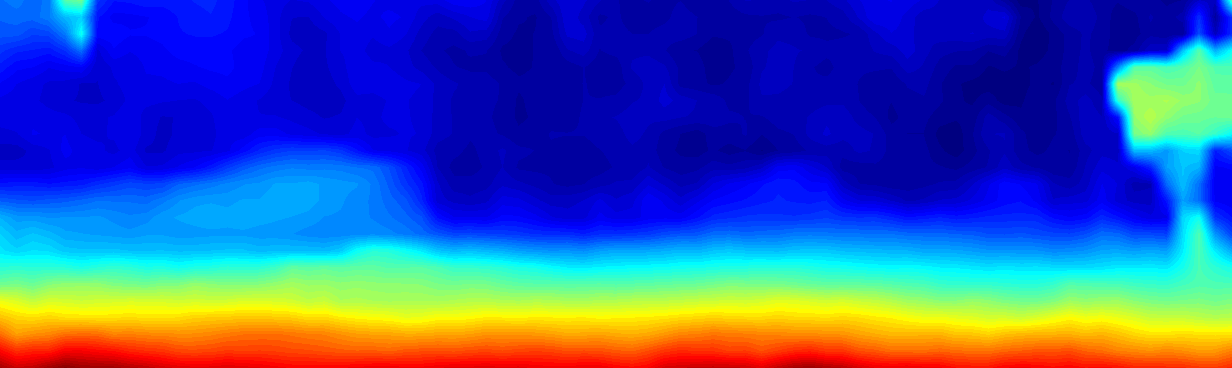

stage 2
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
uint8


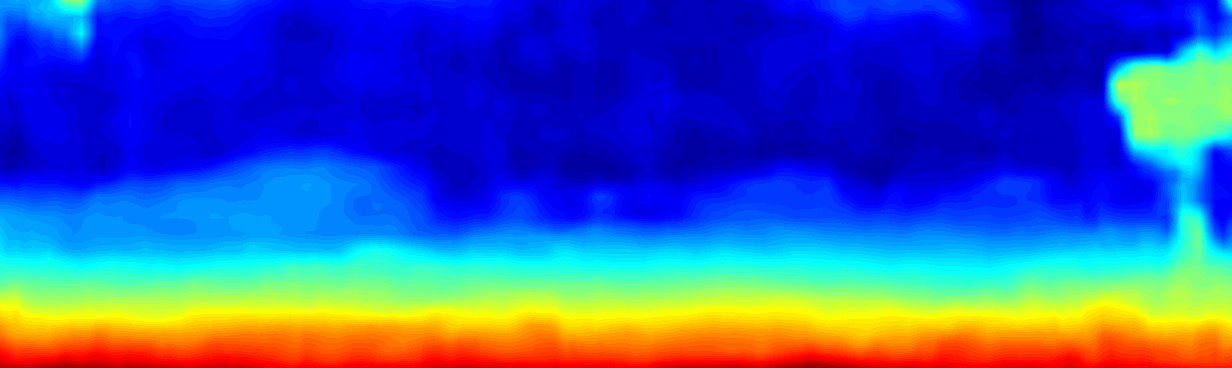

stage 3
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
uint8


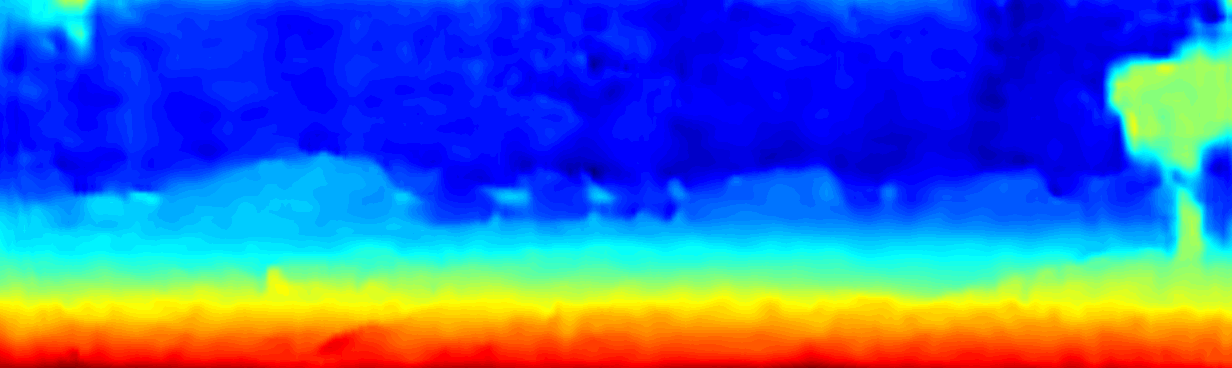

stage 4
bf squeeze : (1, 1, 368, 1232)
af squeeze : (368, 1232)
uint8


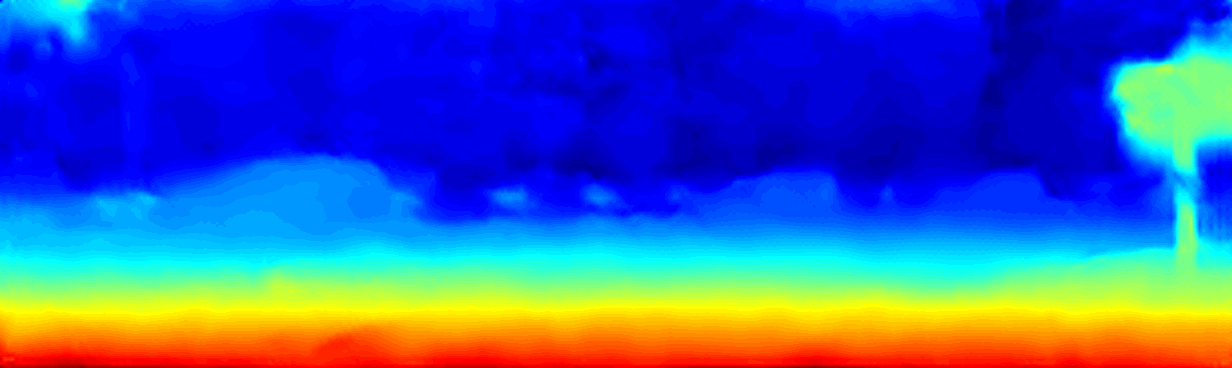

In [68]:
left = '/content/KITTI_SceneFlow2015/testing/image_2/000000_10.png'
right = '/content/KITTI_SceneFlow2015/testing/image_3/000000_10.png'
pr = predict(left, right)

show_tensor(pr)

In [ ]:
!wget https://github.com/Miragecore/cando/raw/iss9/sample/frame0001.jpg
!wget https://github.com/Miragecore/cando/raw/iss9/sample/frame0002.jpg

shape af tf & unsqueeze: torch.Size([1, 3, 480, 640])
tensor len :4
stage 1
bf squeeze : (1, 1, 480, 640)
af squeeze : (480, 640)
uint8


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


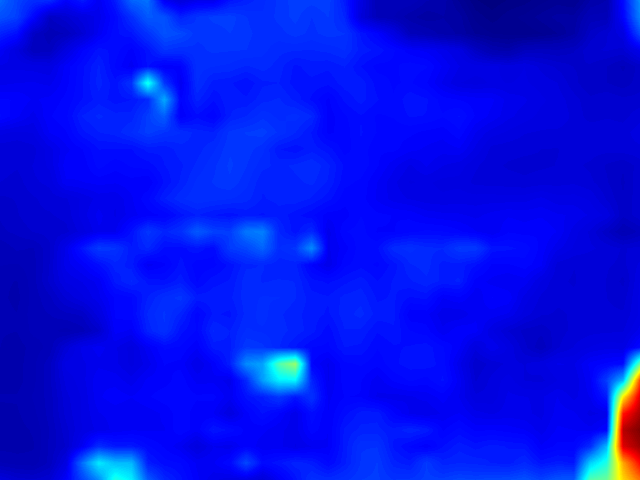

stage 2
bf squeeze : (1, 1, 480, 640)
af squeeze : (480, 640)
uint8


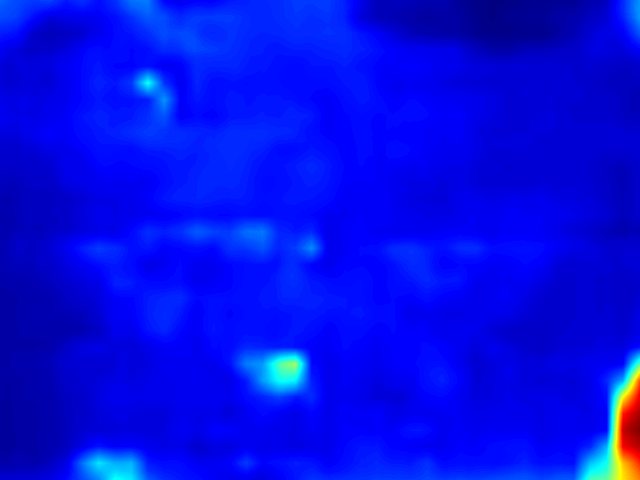

stage 3
bf squeeze : (1, 1, 480, 640)
af squeeze : (480, 640)
uint8


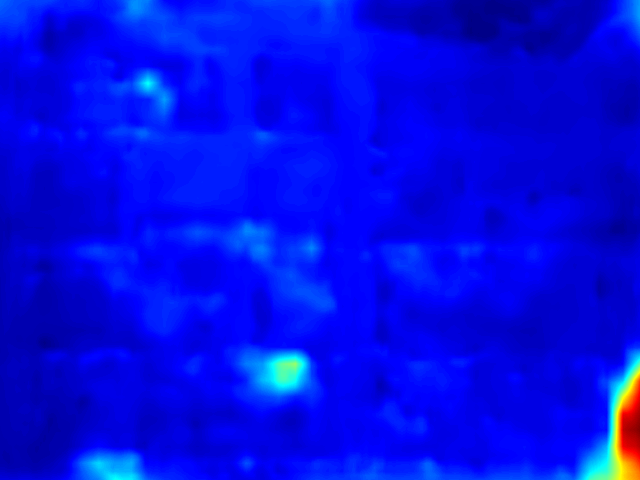

stage 4
bf squeeze : (1, 1, 480, 640)
af squeeze : (480, 640)
uint8


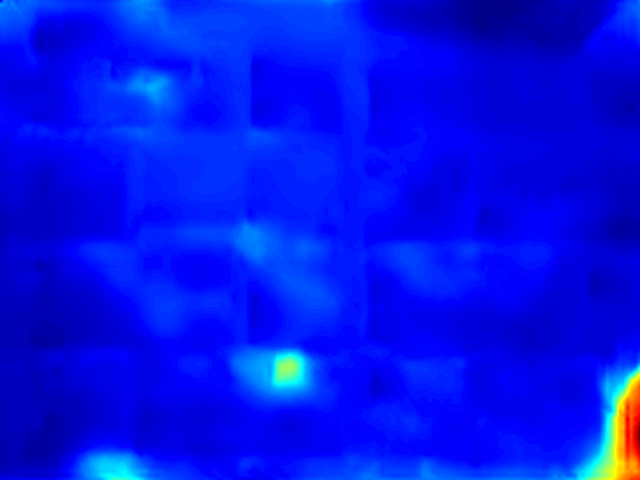

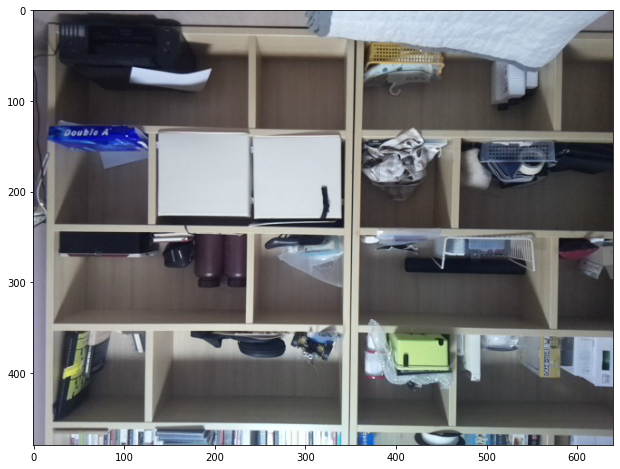

In [69]:
left = '/content/frame0002.jpg'
right = '/content/frame0001.jpg'
pr = predict(left, right, crops=(0,0,640,480))

fs = (12,8)
show_tensor(pr,fs)

import matplotlib.image as img
left_img = img.imread(left)
fig = plt.figure(figsize=fs)
plt.imshow(left_img)
plt.show()